## Finding Patterns in Statsbomb Data: Non-Negative Matrix Factorization Applications

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
from PyFootballPitch.drawpitch import drawpitch

import warnings
warnings.filterwarnings('ignore')

Let's first read in the data.

If you have not read my article on getting and processing the data https://github.com/znstrider/znstrider.github.io/blob/master/_posts/2018-11-11-Getting_Started_with_StatsBomb_Data.md, you can do so now.

Since first posting that article, I have updated it to include a lineups DataFrame that includes minutes played for every player and every match.<br>
We can use that later on to adjust actions for time played.

In [2]:
# set mypath to your /open-data-master/data/ directory
mypath = 
df = pd.read_hdf(mypath+'Statsbomb_Data_df.hdf')
ff_df = pd.read_hdf(mypath+'Statsbomb_Data_ff_df.hdf')
matches_df = pd.read_hdf(mypath+'Statsbomb_Data_matches_df.hdf')
lineups_df = pd.read_hdf(mypath+'Statsbomb_Data_lineups_df.hdf')

In [3]:
playtime = lineups_df.groupby(['player_name'])['minutes_played'].sum()

Let's filter the data for World Cup Matches

In [4]:
wc_match_ids = matches_df.loc['43', 'match_id'].astype('str').values
nwsl_match_ids = matches_df.loc['49', 'match_id'].astype('str').values
fawsl_match_ids = matches_df.loc['37', 'match_id'].astype('str').values

wc_df = df.loc[df.match_id.isin(wc_match_ids), :]
nwsl_df = df.loc[df.match_id.isin(nwsl_match_ids), :]
fawsl_df = df.loc[df.match_id.isin(fawsl_match_ids), :]

Now we can filter te dataset for what we need.

First I want to look at defensive actions.<br>
That means Pressure events, Ball Recoveries, Blocks, Fouls, Tackles, Interceptions and Aerials.<br>
For Aerials I am only looking at clearances, because it seems 'miscontrol_aerial_won' and 'pass_aerial_won' can both be defensive or offensive actions.<br>

In [5]:
# We can create the Tackle events from the duel_type_name
# I am assuming that like with Opta Data, all Tackles are successful events - correct me if I'm wrong.
wc_df.loc[:, 'Tackle'] = wc_df.duel_type_name.apply(lambda x: True if x == 'Tackle' else np.nan)

## Dimensionality Reduction: Non-Negative Matrix Factorization (NMF)
How do we make sense of raw x,y event data?
How do we find patterns in it?

A first approach would be to divide the pitch into bins.
You could divide the pitch into 6 zones horizontally (sides, halfspaces, left center, right center) and 6 zones vertically.

This allows you to categorize better where players make their actions.
The problem is, this also loses a lot of information in the sense that the bins are rather large and you cannot reliably compare players actions, as there is a lot of variation within bins.

To not lose as much information, you could decide to make the bins much smaller and divide the pitch into 5x5 metre (or even smaller) bins.
Now this allows you to much more exactly categorize where players make their actions.<br>
The problem with this approach is, suddenly you are back to having to compare hundreds of bins!
Even with a good visualization, that is not easy to do. 

Is there a way to reduce the number of dimensions to make the data much <b>more interpretable</b> while also <b>gaining meaning</b> and <b>not <i>losing much information</i></b>?
This is where dimensionality reduction techniques come into play.

You may have heard of Principal Component Analysis (PCA) or Singular Value Decomposition (SVD) which are able to decompose a Matrix of Observations and Features into it’s principal parts into a lower dimension - parts that describe the most variance respectively hold the most information.

Non-Negative Matrix Factorization (NMF) is similar, only it imposes another constraint, that all values of V and the matrices W and H it is decomposed into be non-negative. This is necessary as there are no negative action counts. 
NMF can be applied as a topic extraction technique.
<br>
<br>
<br>
In our case, NMF will learn for us

1) a representation of N <b>spatial components - our topics -</b> that hold the most information.<br>
2) Alongside those spatial components we will get <b>weights for each player</b> which show <i>how much a player ‚uses' that component</i>.

For example one component is based on the very right side of the pitch, stretched out along the vertical axis. This is a component featured heavily by right fullbacks and right wingers.
The same holds for a lot of other positional patterns. You will see this in the plots below.

To sum it up the model learns spatial components specific to groups of players, and allows us to measure how heavily involved players are in those topics.

I deliberately tried to keep this explanation simple. Justin Jacobs (@squared2020) has a really good blog post up at https://squared2020.com/2018/10/04/understanding-trends-in-the-nba-how-nnmf-works/ that goes into a little more detail for those interested in the technicalities.

Now let's dig into the actual analysis:

In [6]:
adjusted_for_time_played = False #set to true if you want to adjust for time played

# Filter for defensive actions
defensive_actions = wc_df.loc[df.type_name.isin(
        (['Pressure', 'Ball Recovery', 'Block', 'Foul Committed', 'Interception']))|
                              (pd.notnull(wc_df.loc[:, 'clearance_aerial_won']))|
                              (pd.notnull(wc_df.loc[:, 'Tackle'])),
        ['player_name', 'location_x', 'location_y', 'type_name']].\
        reset_index().rename(columns = {'level_0': 'match_id'}).\
        set_index(['player_name','match_id', 'id']).sort_index()

if not adjusted_for_time_played:
    binned_values = []

    indices = defensive_actions.index.levels[0]
    #for each player
    for player in indices:
        # bin the actions into a 2-dimensional grid 
        binned, bins_x, bins_y = np.histogram2d(defensive_actions.loc[player, 'location_x'],
                                     defensive_actions.loc[player, 'location_y'],
                                     bins = ([np.arange(0,125,5),
                                             np.arange(0,85,5)]))
        #append to our binned data in flattened format
        binned_values.append(binned.ravel())

else:
    mask = playtime[playtime >= 150].index
    defensive_actions = defensive_actions.reset_index().\
    loc[defensive_actions.reset_index()['player_name'].isin(mask), :].\
    set_index('player_name')
    
    binned_values = []

    #indices = defensive_actions.index.levels[0]
    indices = defensive_actions.index.unique()
    for player in indices:
        binned, bins_x, bins_y = np.histogram2d(defensive_actions.loc[player, 'location_x'],
                                     defensive_actions.loc[player, 'location_y'],
                                     bins = ([np.arange(0,125,5),
                                             np.arange(0,85,5)]))
        binned_values.append(binned.ravel()
                             / (playtime.loc[player] / 90) #adjusting for time played
                               )

I also tried adjusting for minutes played, but unfortunately the small sample size for most of the players made the results come out rather badly.

With filtering out players with < 150 min that worked much better, but as a lot of unknowns show up there, I chose to stick with the unfiltered dataset.<br>
Feel free to download the [notebook](') to uncomment and you can also change the N of model components below. <br>
I tried out various N's and chose one where results passed the eye test, ideally one would look to choose the N that minimized the loss - the difference between the original data matrix and the given approximation by the NMF Algorithm.

To get the most out of this kind of analysis, I assume possession adjusting the counts as well as normalizing based on minutes played is the way to go. With the small dataset at hand I'd rather show some sensible patterns and players though.

As you will see, the model components do capture some patterns really nicely as is, but I assume the numbers to not be very meaningful as players with most games will register the most actions and thus will show the biggest influence.

Keep that in mind.

In [7]:
from sklearn.decomposition import NMF
N = 12
import string
cols = [s for s in string.ascii_uppercase[:N]]

bin_freqs = np.vstack(binned_values)
model = NMF(n_components=N, init='random', random_state=0)
W = model.fit_transform(bin_freqs)
H = model.components_

weights = pd.DataFrame(W,
             index = indices,
             columns = cols)

In [8]:
print('Nr of Players(Rows) in the Dataset: ', len(indices),
      '\nShape of Matrix W: ', W.shape,
      '\nShape of Matrix H: ', H.shape)

Nr of Players(Rows) in the Dataset:  600 
Shape of Matrix W:  (600, 12) 
Shape of Matrix H:  (12, 384)


## The Spatial Components for Defensive Activities

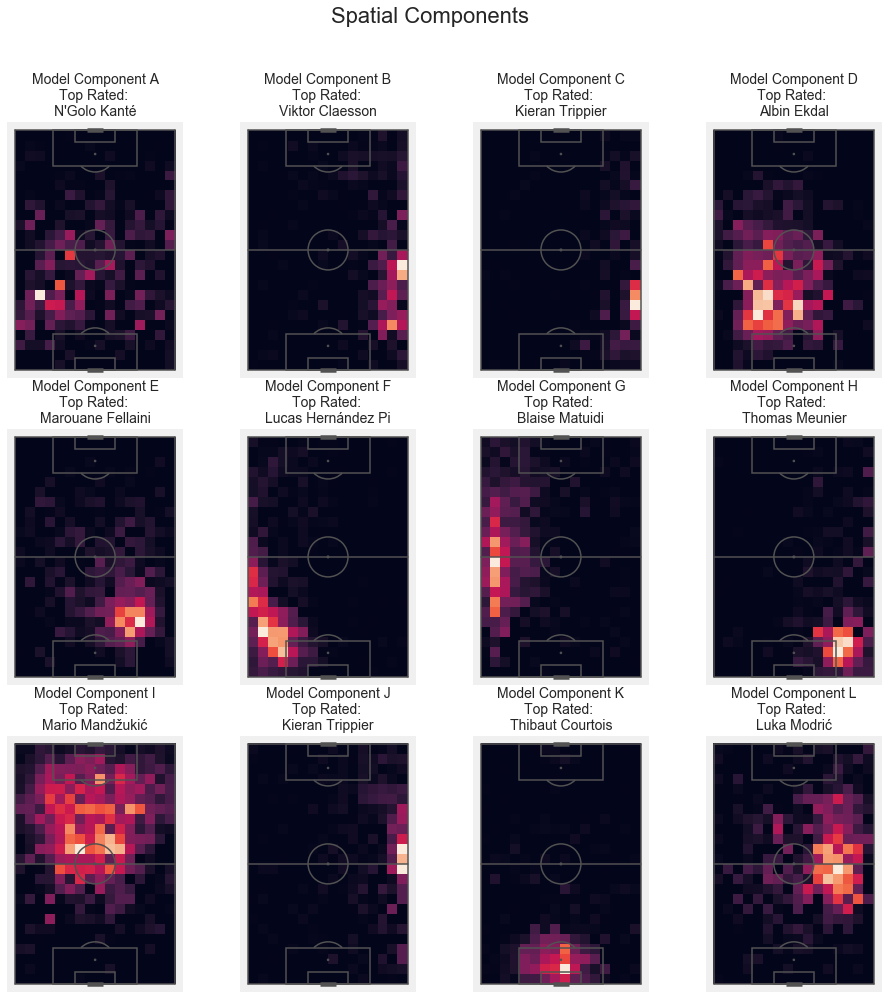

In [9]:
fig, ax = plt.subplots(int(H.shape[0]/4), 4, figsize = (16,16))
ax = ax.flatten()

top_rated = weights.idxmax().values

X, Y = np.meshgrid(bins_x, bins_y)
for i in range(H.shape[0]):
    drawpitch(ax = ax[i], measure = 'SB', orientation = 'vertical')
    plt.sca(ax[i])
    plt.pcolor(Y.T,
               X.T,
               H[i, :].reshape(-1, len(bins_y)-1))
    plt.title('Model Component '+cols[i] + '\nTop Rated: \n' + top_rated[i], fontsize = 14)  
plt.suptitle('Spatial Components', fontsize = 22);

As you can see, this does capture some positional patterns really well:<br>
A: Defensive Midfielder<br>
B: Right Midfielder<br>
C: Right Fullback<br>
D: Left Defensive Midfielder<br>
E: Right Defensive Midfielder<br>
F: Left Back<br>
G: Left Midfielder<br>
H: Right Back<br>
I: Center Forward<br>
J: (another) Right Back<br>
K: Goalkeeper<br>
L: Right Center Midfield

It also shows a problem that might arise:<br>
The approach might not always be able to differentiate between very similar positional components.

#### Below you will see the reconstructed binned player values for each of the above top-rated players for each of the model components. <br>
That's what the model would predict their defensice output to be:

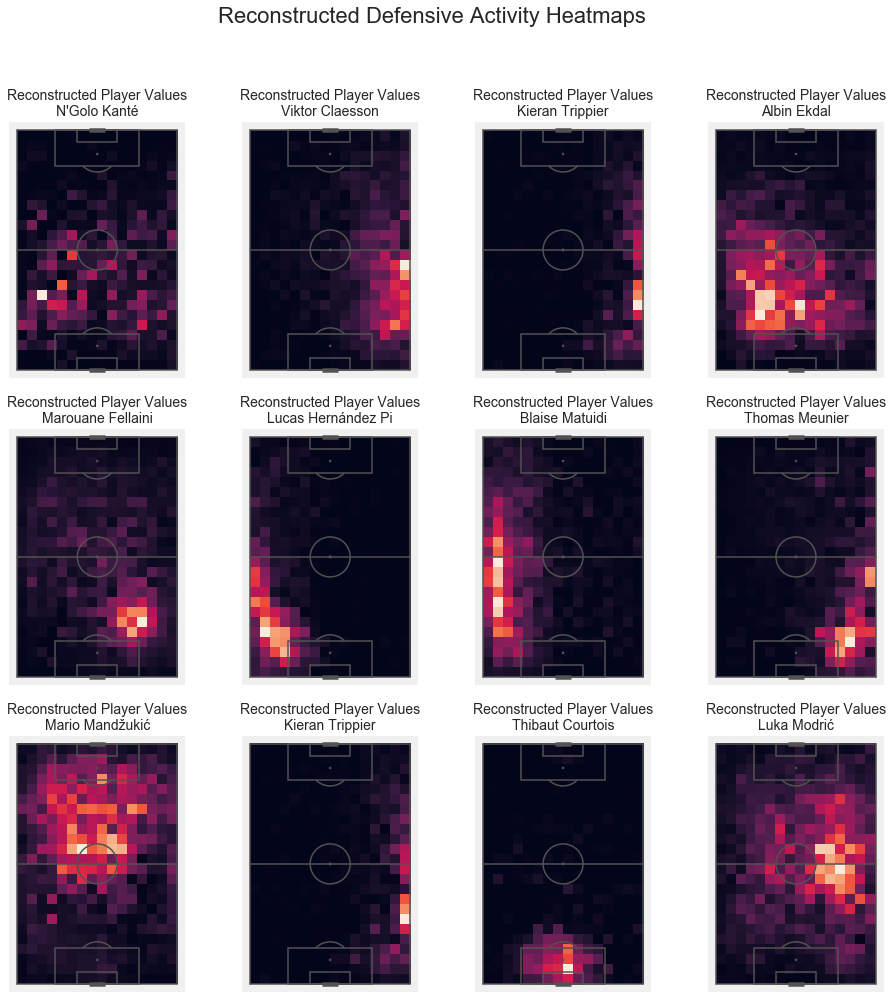

In [10]:
fig, ax = plt.subplots(int(H.shape[0]/4), 4, figsize = (16,16))
ax = ax.ravel()

top_rated = weights.idxmax().values

for i, player in enumerate(top_rated):
    plt.sca(ax[i])
    plt.gca().set_aspect('equal')
    drawpitch(ax = ax[i], measure = 'SB', orientation = 'vertical')
    plt.pcolor(Y.T,
               X.T,
               weights.loc[player].dot(H).reshape(-1, len(bins_y)-1) )
    plt.title('Reconstructed Player Values\n' + top_rated[i], fontsize = 14)  
plt.suptitle('Reconstructed Defensive Activity Heatmaps', fontsize = 22);

#### As comparison, below you will see the ACTUAL defensive activity heatmaps for the top rated players of each component.

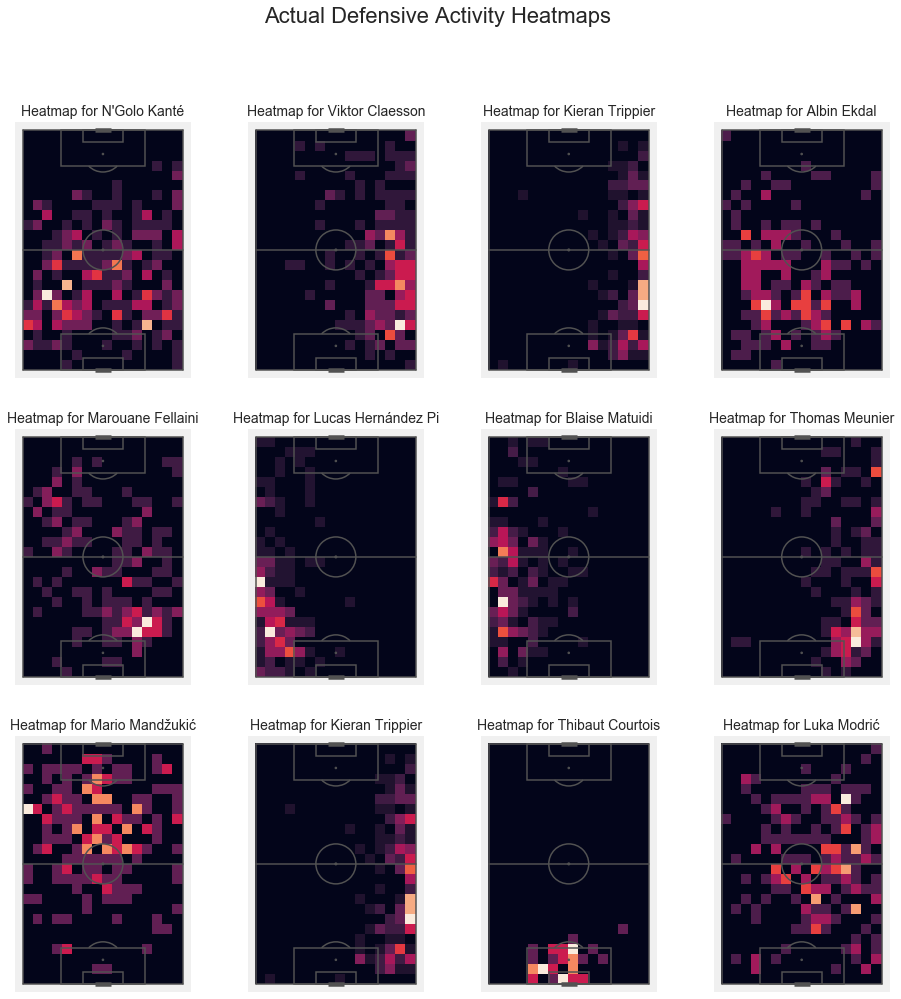

In [11]:
fig, ax = plt.subplots(int(H.shape[0]/4), 4, figsize = (16,16))
ax = ax.ravel()

top_rated = weights.idxmax().values

for i, player in enumerate(top_rated):
    plt.sca(ax[i])
    binned, bins_x, bins_y = np.histogram2d(defensive_actions.loc[player, 'location_x'],
                                 defensive_actions.loc[player, 'location_y'],
                                 bins = ([np.arange(0,125,5),
                                         np.arange(0,85,5)]))
    X, Y = np.meshgrid(bins_x, bins_y)
    drawpitch(ax = ax[i], measure = 'SB', orientation = 'vertical')
    plt.pcolor(Y.T,
               X.T,
               binned)
    plt.title('Heatmap for ' + top_rated[i], fontsize = 14)
plt.suptitle('Actual Defensive Activity Heatmaps', fontsize = 22);

We can see that the spatial patterns are learned quite nicely.<br>
A cool feature of this approach is, that for Mario Mandžukić and Luka Modrić, the model actually <b>fills in the gaps!</b><br>
The reconstructed heatmaps are somewhat amplified and smoothed out.
With the noted execption of N'Golo Kanté - he is truly special.

Let's gather some more information on how values are distributed within the components:

In [12]:
weights.describe().round(3)

,A,B,C,D,E,F,G,H,I,J,K,L
count,600.000,600.000,600.000,600.000,600.000,600.000,600.000,600.000,600.000,600.000,600.000,600.000
mean,0.206,0.239,0.133,0.149,0.137,0.111,0.142,0.072,0.170,0.084,0.088,0.144
std,0.717,0.588,0.341,0.270,0.279,0.268,0.279,0.170,0.330,0.189,0.171,0.258
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.000,0.000,0.000,0.028,0.005,0.001,0.001,0.000,0.016,0.000,0.007,0.008
75%,0.198,0.214,0.122,0.170,0.156,0.090,0.149,0.057,0.196,0.077,0.102,0.200
max,14.025,5.755,5.110,2.159,2.627,3.170,2.605,1.687,2.722,1.819,1.445,2.287


Values at the 50th percentile range between 0 and 0.03,
at the 75th between 0.05 to 0.22,
while maximum values range from about 1.5 to over 14.

Now, what this allows us to do is, look at which players show the highest values for a model component we are interested in.<br>
Who for example is most similar in defensive activity in the component lead by N'Golo Kanté?

In [13]:
weights.A.sort_values(ascending = False)[:10]

player_name
N'Golo Kanté                14.025341
Vahid Amiri                  5.078418
Roman Zobnin                 4.254000
Denis Cheryshev              2.758362
Paul Labile Pogba            2.544006
Rodrigo Bentancur Colmán     2.135550
Ola Toivonen                 2.084988
Onyinye Ndidi                2.045143
Yassine Meriah               1.923451
Antoine Griezmann            1.857233
Name: A, dtype: float64

Who are the strikers that put in defensive activity all across the opposing side of the pitch as well as into their own half like Mario Mandžukić?

In [14]:
weights.I.sort_values(ascending = False)[:10]

player_name
Mario Mandžukić      2.722239
Harry Kane           2.109760
Falcao               2.075953
Ivan Rakitić         1.940288
Gabriel Jesus        1.920490
Antoine Griezmann    1.827962
Marcus Berg          1.783312
Ola Toivonen         1.690852
Artem Dzyuba         1.628784
Kevin De Bruyne      1.561835
Name: I, dtype: float64

And we can look at specific players we are interested in.

In [15]:
weights.loc[top_rated[0], :]

A    14.025341
B     0.298928
C     0.518126
D     0.000000
E     0.797850
F     0.089665
G     0.000000
H     0.124631
I     0.000000
J     0.000000
K     0.032220
L     0.203027
Name: N'Golo Kanté, dtype: float64

In addition to killing it in component A, N'Golo Kanté has decent values in components B,C,E, L and H - all towards the right side, mostly in one's own half.

We can also look at who scores best across all components. This might be useful. Who knows ¯|_(ツ)_/¯

In [16]:
weights.sum(axis=1).sort_values(ascending=False)[:10]

player_name
N'Golo Kanté                    16.089788
Viktor Claesson                  9.281645
Roman Zobnin                     8.431647
Kieran Trippier                  7.342967
Mário Figueira Fernandes         7.176085
Paul Labile Pogba                6.876051
Vahid Amiri                      6.824149
Thomas Meunier                   6.435447
Aleksandr Samedov                6.298756
Nahitan Michel Nández Acosta     6.150166
dtype: float64

### Who is the female N'Golo Kanté?

We can transform the women soccer league's data, to see who shows up high in the spatial components:

In [17]:
f_df = pd.concat([fawsl_df, nwsl_df], axis=0)

f_df.loc[:, 'Tackle'] = f_df.duel_type_name.apply(lambda x: True if x == 'Tackle' else np.nan)

# Filter for defensive actions
f_defensive_actions = f_df.loc[df.type_name.isin(
        (['Pressure', 'Ball Recovery', 'Block', 'Foul Committed', 'Interception']))|
                              (pd.notnull(wc_df.loc[:, 'clearance_aerial_won']))|
                              (pd.notnull(wc_df.loc[:, 'Tackle'])),
        ['player_name', 'location_x', 'location_y', 'type_name']].\
        reset_index().rename(columns = {'level_0': 'match_id'}).\
        set_index(['player_name','match_id', 'id']).sort_index()

mask = playtime[playtime >= 150].index
f_defensive_actions = f_defensive_actions.reset_index().\
loc[f_defensive_actions.reset_index()['player_name'].isin(mask), :].\
set_index('player_name')

binned_values_f = []

indices = f_defensive_actions.index.unique()
for player in indices:
    binned, bins_x, bins_y = np.histogram2d(f_defensive_actions.loc[player, 'location_x'],
                                 f_defensive_actions.loc[player, 'location_y'],
                                 bins = ([np.arange(0,125,5),
                                         np.arange(0,85,5)]))
    binned_values_f.append(binned.ravel()
                         / (playtime.loc[player] / 90) #adjusting for time played
                           )

bin_freqs_f = np.vstack(binned_values_f)
W_f = model.transform(bin_freqs_f)

weights_f = pd.DataFrame(W_f,
             index = indices,
             columns = cols)

In [18]:
weights_f.A.sort_values(ascending = False).iloc[:10]

player_name
Abbey-Leigh Stringer            0.848773
Meggie Dougherty Howard         0.534602
Aileen Whelan                   0.505442
Angharad James                  0.429978
Jessica Fishlock                0.404340
Caprice Dydasco                 0.388294
Julie Biesmans                  0.369698
Lucy Staniforth                 0.341640
Danielle Colaprico              0.332163
Estefanía Romina Banini Ruiz    0.321070
Name: A, dtype: float64

#### It's Evertons Abbey-Leigh Stringer!
Honorable Mention to American Meggie Dougherty Howard

In [19]:
pd.concat([weights_f.loc['Abbey-Leigh Stringer', :], weights.loc["N'Golo Kanté", :]], axis = 1)

,Abbey-Leigh Stringer,N'Golo Kanté
A,0.848773,14.025341
B,0.289105,0.298928
C,0.000000,0.518126
D,0.069631,0.000000
E,0.129028,0.797850
F,0.000000,0.089665
G,0.064988,0.000000
H,0.000000,0.124631
I,0.015926,0.000000
J,0.000000,0.000000


### A few other possible applications:

## Does this also help us to better categorize positioning on offensive actions?

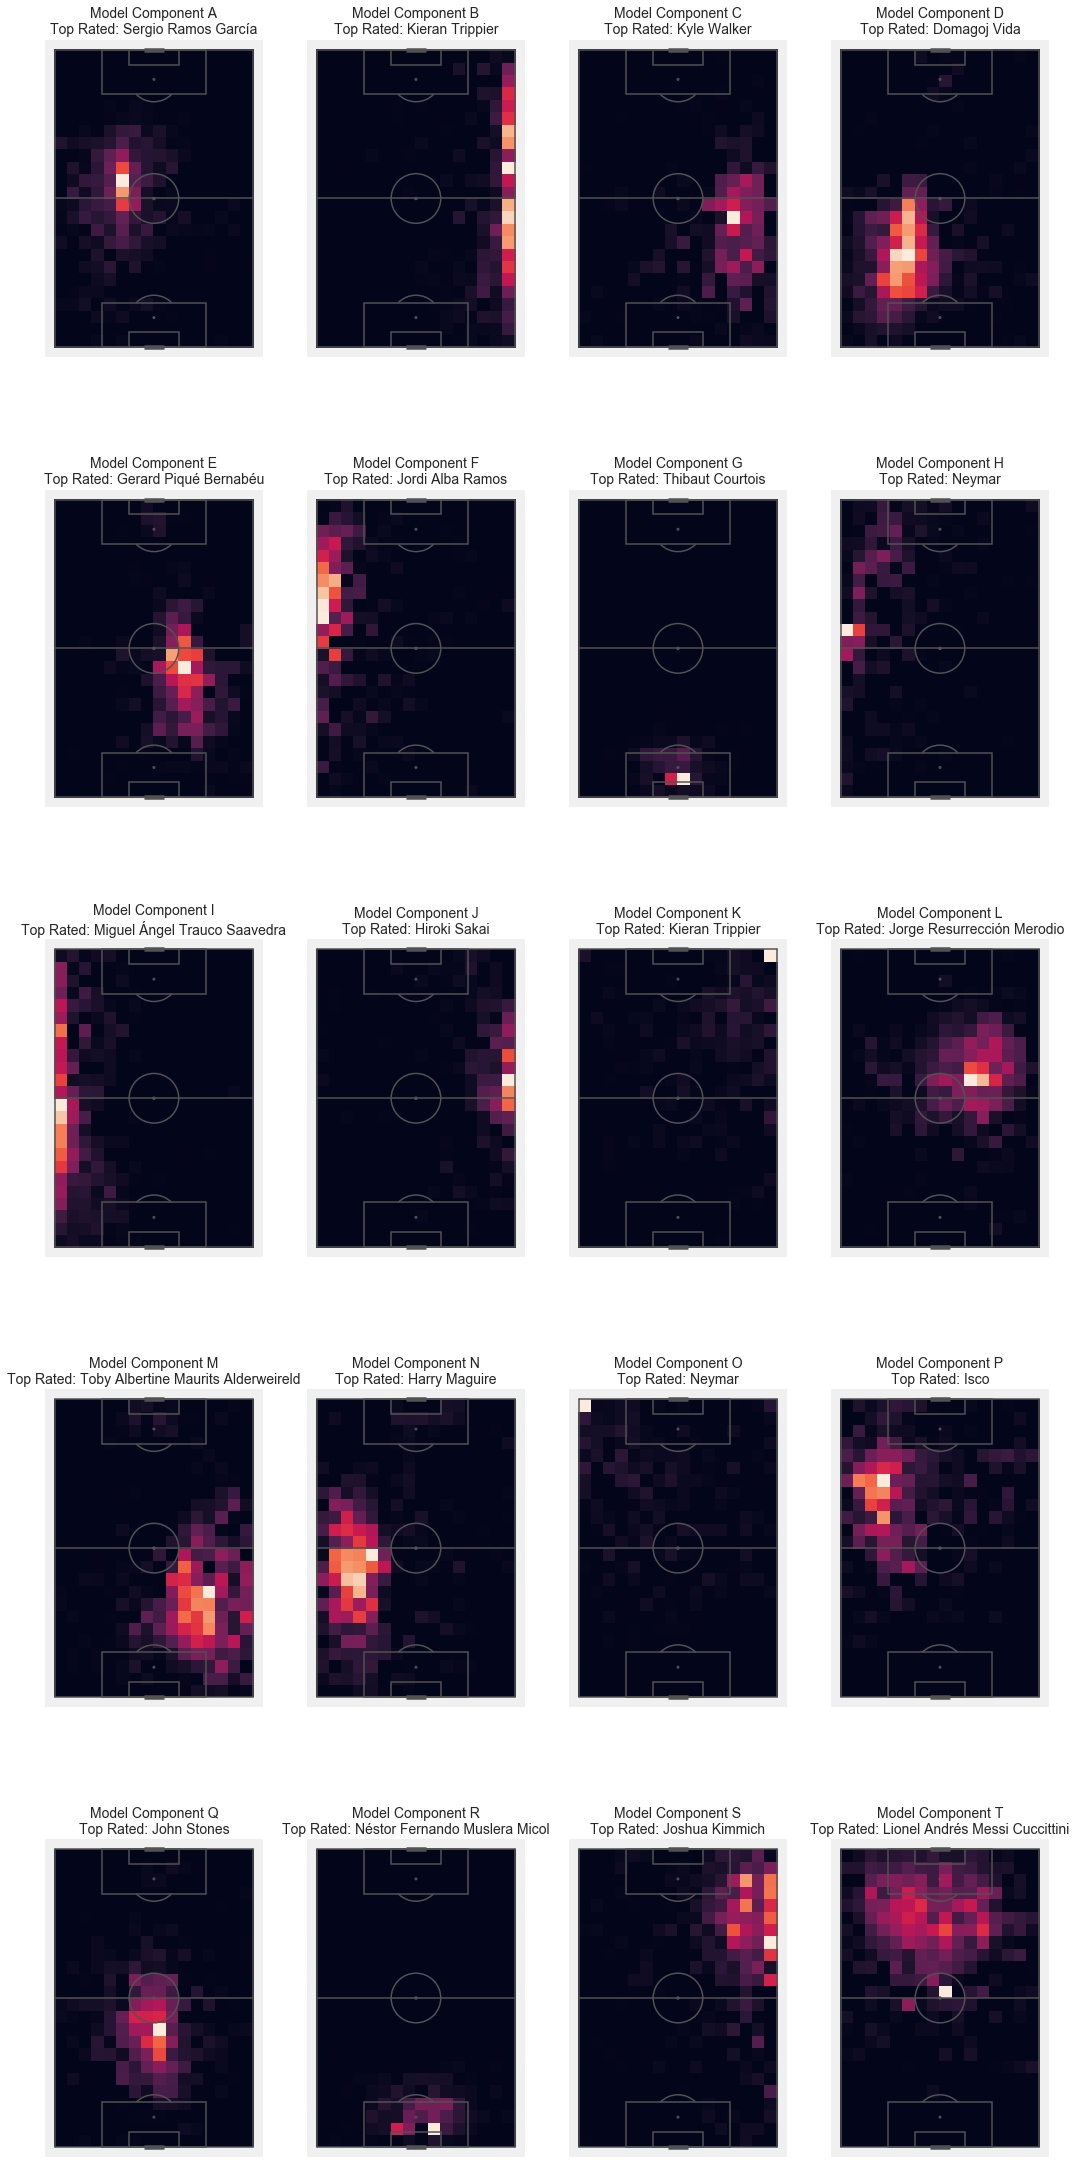

In [20]:
offensive_actions = wc_df.loc[df.type_name.isin(
        ['Shot', 'Pass', 'Ball Receipt', 'Dribble', 'Foul Won']),
        ['player_name', 'location_x', 'location_y', 'type_name']].\
        reset_index().rename(columns = {'level_0':'match_id'}).\
        set_index(['player_name', 'match_id', 'id']).sort_index()

binned_values = []
for player in offensive_actions.index.levels[0]:

    binned, bins_x, bins_y = np.histogram2d(offensive_actions.loc[player, 'location_x'],
                                 offensive_actions.loc[player, 'location_y'],
                                 bins = ([np.arange(0,125,5),
                                         np.arange(0,85,5)]))
    binned_values.append(binned.ravel() 
                        # / (playtime.loc[player] / 90)
                        )
    
from sklearn.decomposition import NMF
N = 20
import string
cols = [s for s in string.ascii_uppercase[:N]]

bin_freqs = np.vstack(binned_values)
model = NMF(n_components=N, init='random', random_state=0)
W = model.fit_transform(bin_freqs)
H = model.components_

weights = pd.DataFrame(W,
             index = offensive_actions.index.levels[0],
             columns = cols)

fig, ax = plt.subplots(int(H.shape[0]/4), 4, figsize = (18,40))
ax = ax.flatten()

top_rated = weights.idxmax().values

X, Y = np.meshgrid(bins_x, bins_y)
for i in range(H.shape[0]):
    drawpitch(ax = ax[i], measure = 'SB', orientation = 'vertical')
    plt.sca(ax[i])
    plt.pcolor(Y.T,
               X.T,
               H[i, :].reshape(-1, len(bins_y)-1))
    plt.title('Model Component '+cols[i] + '\nTop Rated: ' + top_rated[i], fontsize = 14)  

I really like how the model is able to capture a lot of positional patterns here. <br>
Especially the corner and set piece takers surprised me a bit.

## Shots

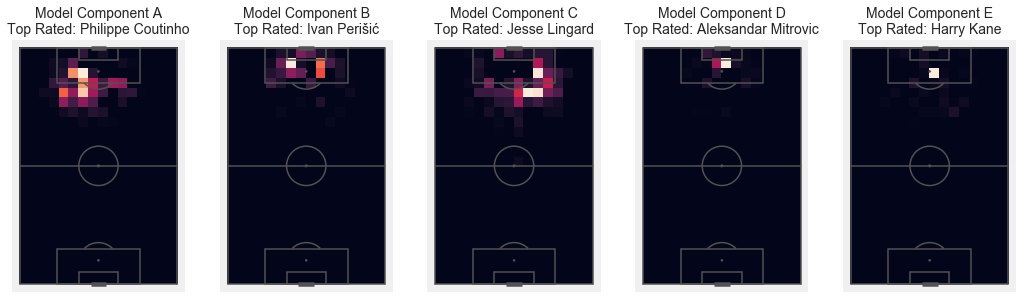

In [21]:
offensive_actions = wc_df.loc[df.type_name.isin(
        ['Shot']),
        ['player_name', 'location_x', 'location_y', 'type_name']].\
        reset_index().rename(columns = {'level_0': 'match_id'}).\
        set_index(['player_name', 'match_id', 'id']).sort_index()

binned_values = []
for player in offensive_actions.index.levels[0]:

    binned, bins_x, bins_y = np.histogram2d(offensive_actions.loc[player, 'location_x'],
                                 offensive_actions.loc[player, 'location_y'],
                                 bins = ([np.arange(0,125,5),
                                         np.arange(0,85,5)]))
    binned_values.append(binned.ravel() 
                        # / (playtime.loc[player] / 90)
                        )
    
from sklearn.decomposition import NMF
N = 5
import string
cols = [s for s in string.ascii_uppercase[:N]]

bin_freqs = np.vstack(binned_values)
model = NMF(n_components=N, init='random', random_state=0)
W = model.fit_transform(bin_freqs)
H = model.components_

weights = pd.DataFrame(W,
             index = offensive_actions.index.levels[0],
             columns = cols)

fig, ax = plt.subplots(int(H.shape[0]/N), N, figsize = (18,12))
ax = ax.flatten()

top_rated = weights.idxmax().values

X, Y = np.meshgrid(bins_x, bins_y)
for i in range(H.shape[0]):
    drawpitch(ax = ax[i], measure = 'SB', orientation = 'vertical')
    plt.sca(ax[i])
    plt.pcolor(Y.T,
               X.T,
               H[i, :].reshape(-1, len(bins_y)-1))
    plt.title('Model Component '+cols[i] + '\nTop Rated: ' + top_rated[i], fontsize = 14) 

## Key Passes

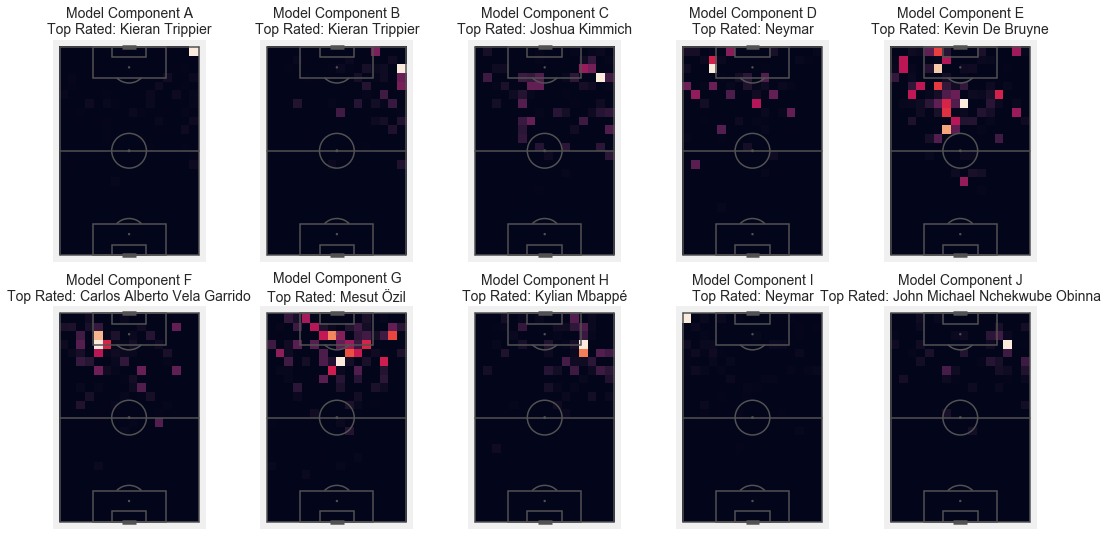

In [22]:
offensive_actions = wc_df.reset_index().loc[wc_df.reset_index().id.isin(wc_df.shot_key_pass_id.dropna().values),
        ['player_name', 'location_x', 'location_y', 'type_name', 'level_0', 'id']].\
        reset_index().rename(columns = {'level_0': 'match_id'}).\
        set_index(['player_name', 'match_id', 'id']).sort_index()

binned_values = []
for player in offensive_actions.index.levels[0]:

    binned, bins_x, bins_y = np.histogram2d(offensive_actions.loc[player, 'location_x'],
                                 offensive_actions.loc[player, 'location_y'],
                                 bins = ([np.arange(0,125,5),
                                         np.arange(0,85,5)]))
    binned_values.append(binned.ravel() 
                        # / (playtime.loc[player] / 90)
                        )
    
from sklearn.decomposition import NMF
N = 10
import string
cols = [s for s in string.ascii_uppercase[:N]]

bin_freqs = np.vstack(binned_values)
model = NMF(n_components=N, init='random', random_state=0)
W = model.fit_transform(bin_freqs)
H = model.components_

weights = pd.DataFrame(W,
             index = offensive_actions.index.levels[0],
             columns = cols)

fig, ax = plt.subplots(int(H.shape[0]/5), 5, figsize = (18,9))
ax = ax.flatten()

top_rated = weights.idxmax().values

X, Y = np.meshgrid(bins_x, bins_y)
for i in range(H.shape[0]):
    drawpitch(ax = ax[i], measure = 'SB', orientation = 'vertical')
    plt.sca(ax[i])
    plt.pcolor(Y.T,
               X.T,
               H[i, :].reshape(-1, len(bins_y)-1))
    plt.title('Model Component '+cols[i] + '\nTop Rated: ' + top_rated[i], fontsize = 14) 

In general with more data this would certainly work better, but overall I am quite pleased of the structures all of the analyses bring to light.
<br>What do you think?
<br>What would you be interested to look at?

<i>A thanks goes out to @KubaMichalczyk who looked over a first draft and provided valuable feedback.<i>